In [1]:
# based on
# scaled up to full MNIST dataset
# https://github.com/SadmanSakib93/Federated-Learning-Keras/blob/main/Fed%20Learning%20-%20FL.ipynb

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Convolution2D, Conv1D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling1D
from keras import backend as K
from keras import backend
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import time
import os
import psutil
import csv
from itertools import repeat
from PIL import Image
from numpy import asarray

2023-02-05 21:20:09.216832: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-05 21:20:09.216852: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from keras.datasets import mnist
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()

xTrain = xTrain.reshape(60000, 784)
xTest = xTest.reshape(10000, 784)
xTrain = xTrain.astype('float32')
x_test = xTest.astype('float32')
xTrain /= 255
x_test /= 255
print(xTrain.shape[0], 'train samples')
print(xTest.shape[0], 'test samples')

# convert class vectors to binary class matrices
yTrain = to_categorical(yTrain, 10)
yTest = to_categorical(yTest, 10)
yTrain.shape

60000 train samples
10000 test samples


(60000, 10)

In [4]:
# Global parameters

verb, epochs, batch_size = 0, 20, 64
numOfIterations = 50
numOfClients  = 5 # do not increase clients too much
modelLocation = "./Models/ANN_Sync_users_"+str(numOfClients)+str(numOfIterations)+"_FL_Model.h5"
accList, precList, recallList, f1List = [], [], [], []

In [5]:
# FOR TEST SPLIT
xServer, xClients, yServer, yClients = train_test_split(xTrain, yTrain, test_size=0.50,random_state=523) 
xServerTest, xClientsTest, yServerTest, yClientsTest = train_test_split(xTrain, yTrain, 
                                                                        test_size=0.50,random_state=523)

In [6]:
def createDeepModel():
   model = Sequential()
   model.add(Dense(16, activation='relu', input_shape=(784,)))
   model.add(Dense(64, activation='relu'))
#   model.add(Dense(64, activation='relu'))
   model.add(Dense(10, activation='softmax'))
   model.summary()
   model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),
              metrics=['accuracy'])
   return model

def predictTestData(yPredict, yTest):
    #Converting predictions to label
    print("yPredict",len(yPredict))
    pred = list()
    for i in range(len(yPredict)):
        pred.append(np.argmax(yPredict[i]))
    #Converting one hot encoded test label to label
    test = list()
    for i in range(len(yTest)):
        test.append(np.argmax(yTest[i]))
    return my_metrics(test, pred)

def sumOfWeights(weights):
    return sum(map(sum, weights))

def getWeights(model):
    allLayersWeights=deepModel.get_weights()
    return allLayersWeights

def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    recall=recall_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, recall, f1Score

In [7]:
# Initially train central deep model
deepModel=createDeepModel()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                12560     
                                                                 
 dense_1 (Dense)             (None, 64)                1088      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 14,298
Trainable params: 14,298
Non-trainable params: 0
_________________________________________________________________


2023-02-05 21:20:11.156617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-05 21:20:11.157085: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-05 21:20:11.157159: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-02-05 21:20:11.157228: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-02-05 21:20:11.159120: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [8]:
def Analyze_training(h):
   f = plt.figure(figsize=(7, 3))
# summarize history for accuracy
# history.history.keys() -> dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
   plt.subplot(1,2,1)
   plt.plot(h.history['accuracy'])
   plt.plot(h.history['val_accuracy'])
   plt.title('model accuracy')
   plt.ylabel('accuracy')
   plt.xlabel('epoch')
   plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
   plt.subplot(1,2,2)
   plt.plot(h.history['loss'])
   plt.plot(h.history['val_loss'])
   plt.title('model loss')
   plt.ylabel('loss')
   plt.xlabel('epoch')
   plt.legend(['train', 'test'], loc='upper left')
   plt.show()
   return

In [9]:
deepModelAggWeights=[]
firstClientFlag=True

def updateServerModel(clientModel, clientModelWeight):
    global firstClientFlag
    for ind in range(len(clientModelWeight)):
        if(firstClientFlag==True):
            deepModelAggWeights.append(clientModelWeight[ind])            
        else:
            deepModelAggWeights[ind]=(deepModelAggWeights[ind]+clientModelWeight[ind])

def updateClientsModels():
    global clientsModelList
    global deepModel
    clientsModelList.clear()
    for clientID in range(numOfClients):
        m = keras.models.clone_model(deepModel)
        m.set_weights(deepModel.get_weights())
        clientsModelList.append(m)
    


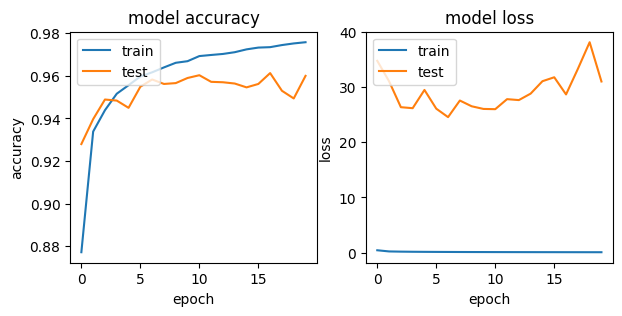

In [10]:
# baseline model non-federated
h = deepModel.fit(xTrain, yTrain,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verb,
                    validation_data=(xTest, yTest))
Analyze_training(h)

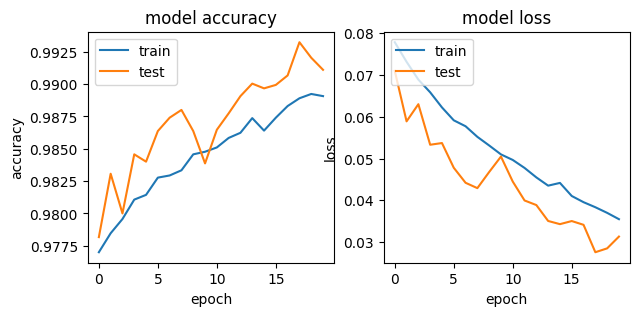

In [11]:
# 1. Train central model initially -----

def trainInServer():
    h = deepModel.fit(xServer, yServer, 
                      epochs=epochs, batch_size=batch_size, verbose=verb,
                      validation_data=(xServerTest, yServerTest))
    deepModel.save(modelLocation)
    Analyze_training(h)
trainInServer()

In [12]:
# ------- 2. Separate clients data into lists ----------
xClientsList=[]
yClientsList=[]
clientsModelList=[]
clientDataInterval=len(xClients)//numOfClients
lastLowerBound=0

for clientID in range(numOfClients):
    xClientsList.append(xClients[lastLowerBound : lastLowerBound+clientDataInterval])
    yClientsList.append(yClients[lastLowerBound : lastLowerBound+clientDataInterval])
    model=load_model(modelLocation)
    clientsModelList.append(model)
    lastLowerBound+=clientDataInterval
yClientsList[1].shape

(6000, 10)

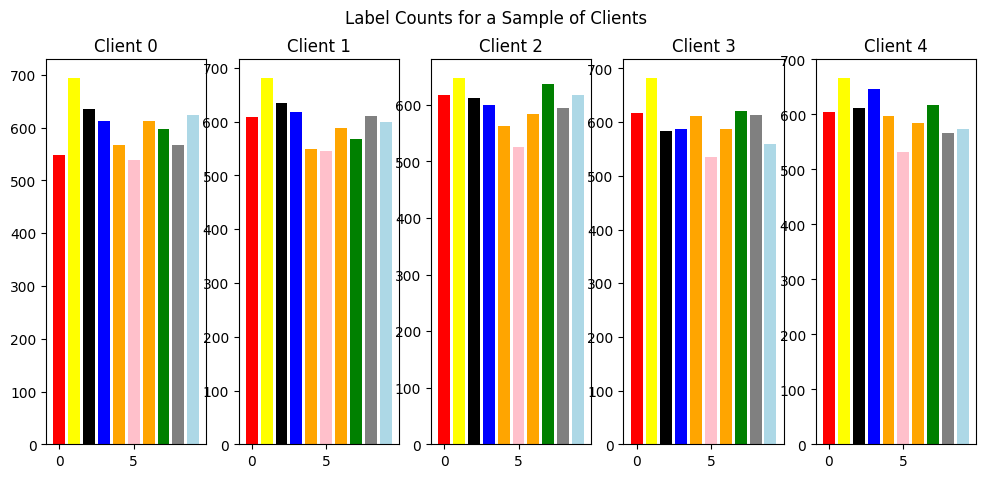

In [13]:
# Number of examples per layer for a sample of clients
import matplotlib.colors as mcolors

c = ['red', 'yellow', 'black', 'blue', 'orange', 'pink', 'orange', 'green', 'grey', 'lightblue']


f = plt.figure(figsize=(12, 5))
f.suptitle('Label Counts for a Sample of Clients')
b = np.arange(0, 10, 1)
for i in range(numOfClients):
    client_dataset = yClientsList[i]
    bin = client_dataset[0]
    for k in range(1,len(client_dataset)):
       bin = bin + client_dataset[k]
    np.squeeze(bin).shape
    plt.subplot(int(numOfClients/5), 5, i+1)
    plt.title('Client {}'.format(i))
    plt.bar(b,bin[b], color = c)
        
       


In [14]:
# ------- 3. Update clients' model with intial server's deep-model ----------

#revisa si estas dos lineas valen
#for clientID in range(numOfClients):
#    clientsModelList[clientID].fit(xClientsList[clientID], yClientsList[clientID], epochs=epochs, batch_size=batch_size, verbose=verbose)
        
start_time = time.time()
process = psutil.Process(os.getpid())
for iterationNo in range(1,numOfIterations+1):
    print("Iteration",iterationNo)
    for clientID in range(numOfClients):
        print("clientID",clientID)
        clientsModelList[clientID].compile(loss='mean_squared_error', optimizer='adam', 
                                          metrics=['accuracy'])
        
        history = clientsModelList[clientID].fit(xClientsList[clientID], yClientsList[clientID], epochs=epochs, 
                                                 batch_size=batch_size, verbose=verb)
#        Analyze_training(history)
        clientWeight=clientsModelList[clientID].get_weights()
        # Find sum of all client's model
        updateServerModel(clientsModelList[clientID], clientWeight)
        firstClientFlag=False
        
    #Average all clients model
    
    for ind in range(len(deepModelAggWeights)):
        deepModelAggWeights[ind]/=numOfClients

    dw_last=deepModel.get_weights()

    for ind in range(len(deepModelAggWeights)): 
        dw_last[ind]=deepModelAggWeights[ind]
     
    #Update server's model
    deepModel.set_weights(dw_last) 
    print("Server's model updated")
    print("Saving model . . .")
    deepModel.save(modelLocation)
    # Servers model is updated, now it can be used again by the clients
    updateClientsModels()
    firstClientFlag=True
    deepModelAggWeights.clear()

    yPredict = deepModel.predict(xTest)
    acc, prec, recall, f1Score= predictTestData(yPredict, yTest)
    accList.append(acc)
    precList.append(prec)
    recallList.append(recall)
    f1List.append(f1Score)
    print("Acc:\n", acc)
    print("Prec:\n", prec)
    print("Recall:\n", recall)
    print("F1-Score:\n", f1Score)



Iteration 1
clientID 0
clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9612
Precision : 0.9615428454760826
Recall : 0.9612
f1Score : 0.9612098632232186
[[ 962    0    2    2    2    2    4    1    3    2]
 [   0 1121    3    1    0    1    4    1    4    0]
 [   5    3  986   13    5    1    3    9    5    2]
 [   0    0    6  986    0    3    2    7    3    3]
 [   2    0    5    2  943    0    9    4    2   15]
 [   6    1    3   29    4  834    3    0    7    5]
 [   9    3    1    2    6    9  922    0    6    0]
 [   2    4   11    7    1    0    0  991    3    9]
 [   7    2   10   23    2    4    2    4  918    2]
 [   6    6    2   13   13    5    0    7    8  949]]
Acc:
 0.9612
Prec:
 0.9615428454760826
Recall:
 0.9612
F1-Score:
 0.9612098632232186
Iteration 2
clientID 0
clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9611
Precision : 0.96163294

clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.961
Precision : 0.9614761434910499
Recall : 0.961
f1Score : 0.961052116812016
[[ 955    0    8    2    3    3    4    1    3    1]
 [   0 1121    2    2    0    1    4    1    4    0]
 [   3    2  993   16    3    0    3    5    6    1]
 [   0    0    7  986    0    2    2    7    3    3]
 [   2    0    5    1  935    0   10    4    5   20]
 [   4    1    4   34    3  831    5    0    9    1]
 [   5    2    2    2    6    7  924    0   10    0]
 [   2    7   11    8    0    0    0  981    5   14]
 [   3    3    8   20    1    3    0    2  931    3]
 [   3    6    3   12   10    9    0    5    8  953]]
Acc:
 0.961
Prec:
 0.9614761434910499
Recall:
 0.961
F1-Score:
 0.961052116812016
Iteration 12
clientID 0
clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9594
Precision : 0.9600565911942828
Recall : 0.9594
f1S

clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9598
Precision : 0.9603360892558443
Recall : 0.9598
f1Score : 0.9598785016206137
[[ 956    0    6    2    4    4    5    1    1    1]
 [   0 1121    2    3    0    1    4    1    3    0]
 [   3    2  991   17    4    0    4    5    5    1]
 [   0    0    9  984    1    2    1    7    3    3]
 [   2    1    3    2  940    0    9    4    2   19]
 [   3    1    4   35    3  833    6    0    6    1]
 [   6    2    3    0    6   12  919    0    9    1]
 [   1    4   12   11    0    1    0  983    4   12]
 [   3    1    9   25    3    7    0    3  921    2]
 [   2    6    3   14   12   10    1    6    5  950]]
Acc:
 0.9598
Prec:
 0.9603360892558443
Recall:
 0.9598
F1-Score:
 0.9598785016206137
Iteration 22
clientID 0
clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9581
Precision : 0.958832718496983
Recall : 0.958

clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9572
Precision : 0.9580081359973467
Recall : 0.9572
f1Score : 0.9573175654745508
[[ 957    0    4    2    4    3    4    1    2    3]
 [   0 1120    1    6    0    1    2    1    4    0]
 [   4    2  993   18    1    0    2    5    5    2]
 [   0    0    6  986    1    2    2    7    3    3]
 [   1    1    7    1  927    0    8    7    2   28]
 [   3    2    3   40    2  829    3    0    8    2]
 [   8    2    3    1    8   12  910    0   13    1]
 [   2    4   15   13    0    1    0  977    4   12]
 [   3    1   14   27    3    7    0    4  913    2]
 [   2    4    3   14    6   10    0    4    6  960]]
Acc:
 0.9572
Prec:
 0.9580081359973467
Recall:
 0.9572
F1-Score:
 0.9573175654745508
Iteration 32
clientID 0
clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9585
Precision : 0.9592053968706185
Recall : 0.95

clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9586
Precision : 0.9592383658587178
Recall : 0.9586
f1Score : 0.9586943841415414
[[ 954    0    6    2    3    3    6    1    2    3]
 [   0 1120    4    4    0    1    2    1    3    0]
 [   4    2  988   18    3    0    3    5    8    1]
 [   0    0    7  986    0    1    3    6    4    3]
 [   1    1    6    2  932    0   10    4    5   21]
 [   2    2    4   37    3  833    4    0    6    1]
 [   6    3    4    1    4   10  917    0   11    2]
 [   1    5   15   11    1    0    0  977    4   14]
 [   3    3   11   23    4    6    1    2  919    2]
 [   2    6    2   12    7   12    0    3    5  960]]
Acc:
 0.9586
Prec:
 0.9592383658587178
Recall:
 0.9586
F1-Score:
 0.9586943841415414
Iteration 42
clientID 0
clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9575
Precision : 0.958255161659483
Recall : 0.957

---Memory--- 5.93786960972649
--- 655.8961238861084 seconds (TRAINING)---


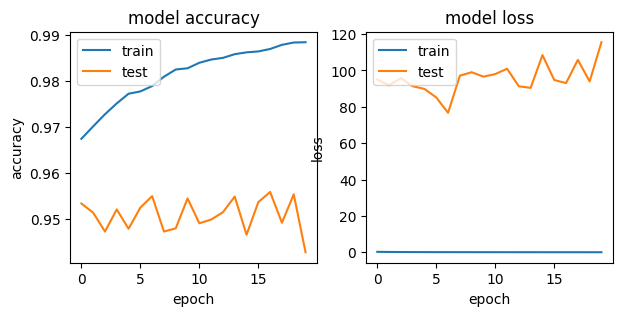

In [15]:
# 3. Evaluation at server

memoryTraining=process.memory_percent()
timeTraining=time.time() - start_time
print("---Memory---",memoryTraining)
print("--- %s seconds (TRAINING)---" % (timeTraining))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=verb, mode='auto')

history = deepModel.fit(xServer, yServer, epochs=epochs, 
                        validation_data = (xTest,yTest), verbose=verb)
                        # callbacks=[early_stopping])

learningAccs = history.history['val_accuracy']
learningLoss=history.history['val_loss']



Analyze_training(history)

In [16]:
# evaluation results
# resultSaveLocation=root_path+'Results/'+algoName+'_Users_vs_TR_vs_Iterations_vs_AccLossMemTime'+'.csv'
dfSave=pd.DataFrame(columns=['Clients', 'Iterations to converge', 'Accuracy', 'Loss', 'Memory', 'Time'])
dfSaveIndex=0
saveList = [numOfClients, len(learningLoss), learningAccs[len(learningAccs)-1], learningLoss[len(learningLoss)-1], memoryTraining, timeTraining]
dfSave.loc[dfSaveIndex] = saveList

yPredict = deepModel.predict(xTest)
acc, prec, recall, f1Score= predictTestData(yPredict, yTest)

print("Number of users:", numOfClients)
deepModel.save(modelLocation)


print("Iterations:", numOfIterations)
print("Memory:", memoryTraining)
print("Time:", timeTraining)
print(dfSave)

df_performance_timeRounds = pd.DataFrame(
    {'Accuracy': accList,
     'Precision': precList,
     'Recall': recallList,
     'F1-Score': f1List 
    })

yPredict 10000
Accuracy  : 0.9427
Precision : 0.9467762792301517
Recall : 0.9427
f1Score : 0.9434879013183165
[[ 951    0    4    5    2    5    9    2    1    1]
 [   0 1100    9   16    0    1    1    4    4    0]
 [   1    2  969   44    0    1    1    5    8    1]
 [   0    1    4  993    0    4    0    3    2    3]
 [   2    0   21    7  907    1    9    8   10   17]
 [   2    1    5   43    2  832    2    2    0    3]
 [   3    3    5    5    5   16  915    0    6    0]
 [   2    3   14   44    0    1    0  948    2   14]
 [   4    1    7   60    2   20    1    1  874    4]
 [   4    3    2   28    7   13    0    7    7  938]]
Number of users: 5
Iterations: 50
Memory: 5.93786960972649
Time: 655.8961238861084
   Clients  Iterations to converge  Accuracy        Loss   Memory        Time
0      5.0                    20.0    0.9427  115.496574  5.93787  655.896124


In [11]:

import session_info
session_info.show()

In [ ]:
#EOF